In [1]:
print("Hello")

Hello


In [2]:
import numpy as np

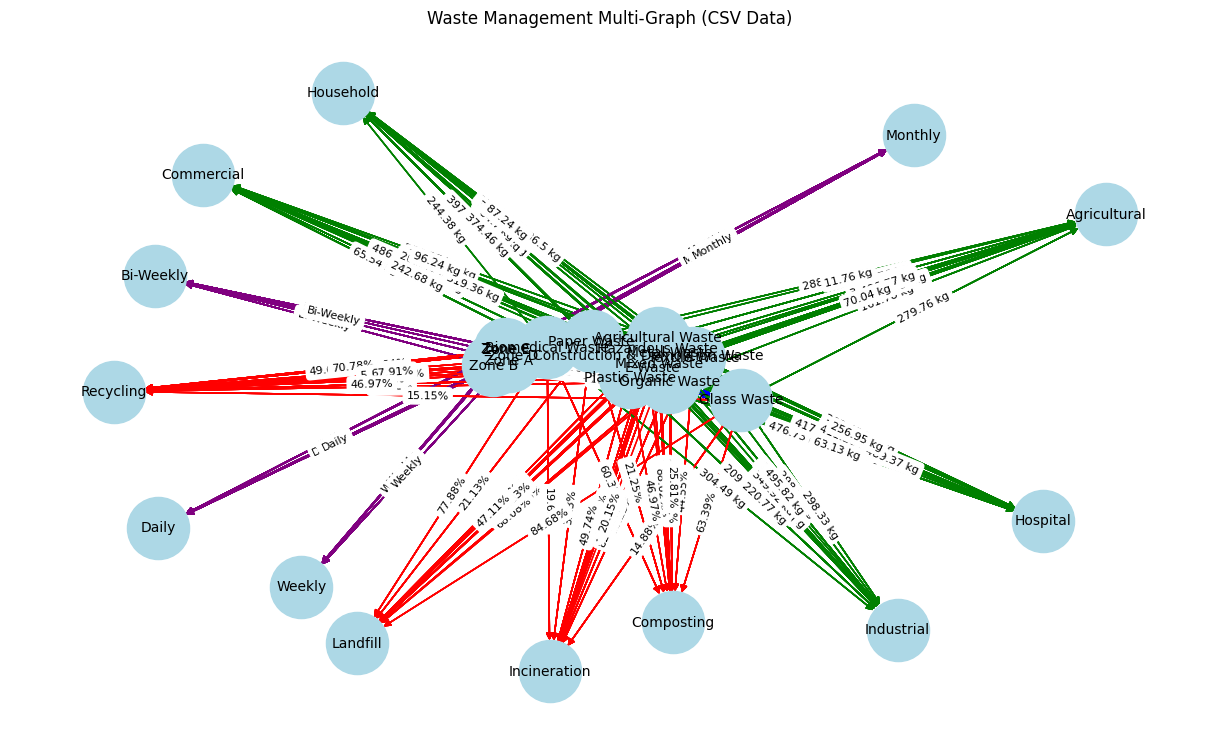

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load CSV file
file_path = "waste_classification_data.csv"  # Update with the actual path
df = pd.read_csv(file_path)

# Create MultiDiGraph
G = nx.MultiDiGraph()

# Add Nodes & Edges
for _, row in df.iterrows():
    area = row["Area Name"]
    waste = row["Waste Type"]
    qty = row["Waste Quantity (kg)"]
    source = row["Source"]
    recyclability = row["Recyclability Score (%)"]
    disposal = row["Disposal Method"]
    frequency = row["Collection Frequency"]

    # Add edges with labels
    G.add_edge(area, waste, weight=qty, label=f"{qty} kg")  # Waste Flow
    G.add_edge(waste, disposal, weight=recyclability, label=f"{recyclability}%")  # Disposal Efficiency
    G.add_edge(waste, source, weight=qty, label=f"{qty} kg")  # Source Contribution
    G.add_edge(area, frequency, weight=qty, label=frequency)  # Collection Frequency

# Define Edge Colors
color_map = {
    "Waste Flow": "blue",
    "Disposal Efficiency": "red",
    "Source Contribution": "green",
    "Collection Frequency": "purple"
}

edge_labels = {}
edge_colors = []

for u, v, data in G.edges(data=True):
    if v in df["Waste Type"].values:
        edge_type = "Waste Flow"
    elif v in df["Disposal Method"].values:
        edge_type = "Disposal Efficiency"
    elif v in df["Source"].values:
        edge_type = "Source Contribution"
    else:
        edge_type = "Collection Frequency"
    
    edge_labels[(u, v)] = data["label"]
    edge_colors.append(color_map[edge_type])

# Draw Graph
plt.figure(figsize=(12, 7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, edge_color=edge_colors, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Waste Management Multi-Graph (CSV Data)")
plt.show()


In [4]:
# **1️⃣ Adjacency Matrix**
A = nx.adjacency_matrix(G).todense()
print("Adjacency Matrix:\n", A)

# **2️⃣ Incidence Matrix**
I = nx.incidence_matrix(G, oriented=True).todense()
print("\nIncidence Matrix:\n", I)

# **3️⃣ Laplacian Matrix (L = D - A)**
D = np.diag(np.array(A.sum(axis=1)).flatten())  # Degree Matrix
L = D - A
print("\nLaplacian Matrix:\n", L)

Adjacency Matrix:
 [[    0.    2617.15     0.       0.   10661.22     0.    5045.22     0.
      0.    1883.24     0.    7873.66     0.    6323.46     0.       0.
   2116.35     0.    3013.51  2527.81     0.       0.    1989.81     0.
   2441.73  4637.99  2132.34  1409.84 10181.22  5224.57]
 [    0.       0.     337.79  1482.87     0.       0.       0.     451.87
      0.       0.    1592.75     0.       0.       0.       0.    2497.03
      0.    2366.71     0.       0.     353.28  1860.27     0.     505.63
      0.       0.       0.       0.       0.       0.  ]
 [    0.       0.       0.       0.       0.       0.       0.       0.
      0.       0.       0.       0.       0.       0.       0.       0.
      0.       0.       0.       0.       0.       0.       0.       0.
      0.       0.       0.       0.       0.       0.  ]
 [    0.       0.       0.       0.       0.       0.       0.       0.
      0.       0.       0.       0.       0.       0.       0.       0.
      0.    

In [5]:
# Extract degree values (sum of outgoing edges per node)
degree_values = np.array(A.sum(axis=1)).flatten()

# Map values to node names
nodes = list(G.nodes)
degree_dict = dict(zip(nodes, degree_values))

# Sort areas by waste amount
sorted_waste_areas = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

print("\nTop Waste-Heavy Areas:")
for area, waste in sorted_waste_areas[:5]:  # Show top 5
    print(f"{area}: {waste} kg")



Top Waste-Heavy Areas:
Zone A: 70079.12 kg
Zone D: 51577.979999999996 kg
Zone C: 51525.280000000006 kg
Zone E: 44798.82 kg
Zone B: 44521.73999999999 kg


In [6]:
# Compute self-loops in Laplacian matrix (L[i][i] values)
laplacian_diagonal = np.diag(L)

# Compare with outgoing edges
inefficiency_dict = {nodes[i]: laplacian_diagonal[i] - degree_values[i] for i in range(len(nodes))}

# Sort by highest inefficiency
sorted_inefficiencies = sorted(inefficiency_dict.items(), key=lambda x: x[1], reverse=True)

print("\nTop Areas with Recycling Inefficiencies:")
for area, ineff in sorted_inefficiencies[:5]:  # Show top 5
    print(f"{area}: Inefficiency Score {ineff}")



Top Areas with Recycling Inefficiencies:
Zone A: Inefficiency Score 0.0
Textile Waste: Inefficiency Score 0.0
Landfill: Inefficiency Score 0.0
Commercial: Inefficiency Score 0.0
Monthly: Inefficiency Score 0.0


In [7]:
# Extract waste production per area
waste_production = {nodes[i]: degree_values[i] for i in range(len(nodes))}

# Extract collection frequency connections
collection_frequencies = {node: 0 for node in nodes}
for u, v, data in G.edges(data=True):
    if v in ["Monthly", "Weekly", "Bi-Weekly"]:
        collection_frequencies[u] += 1
# Avoid division by zero by ensuring denominator is at least 1
collection_issues = {
    area: waste_production[area] / max(collection_frequencies.get(area, 1), 1)
    for area in waste_production.keys()
}

# Sort by inefficiency
sorted_collection_issues = sorted(collection_issues.items(), key=lambda x: x[1], reverse=True)

print("\nAreas with Waste Collection Inefficiencies:")
for area, issue_score in sorted_collection_issues[:5]:  # Show top 5
    print(f"{area}: Inefficiency Score {issue_score}")



Areas with Waste Collection Inefficiencies:
Plastic Waste: Inefficiency Score 16963.63
Paper Waste: Inefficiency Score 15144.64
Agricultural Waste: Inefficiency Score 14656.8
Mixed Waste: Inefficiency Score 14161.78
Construction & Demolition Waste: Inefficiency Score 13906.369999999999


Epoch 0, Loss: 3.832132577896118
Epoch 10, Loss: 1.0153640508651733
Epoch 20, Loss: 0.9558607935905457
Epoch 30, Loss: 0.7880954146385193
Epoch 40, Loss: 0.7130128145217896
Epoch 50, Loss: 0.6851643919944763
Epoch 60, Loss: 0.6410242319107056
Epoch 70, Loss: 0.6068790555000305
Epoch 80, Loss: 0.5718317031860352
Epoch 90, Loss: 0.53919517993927


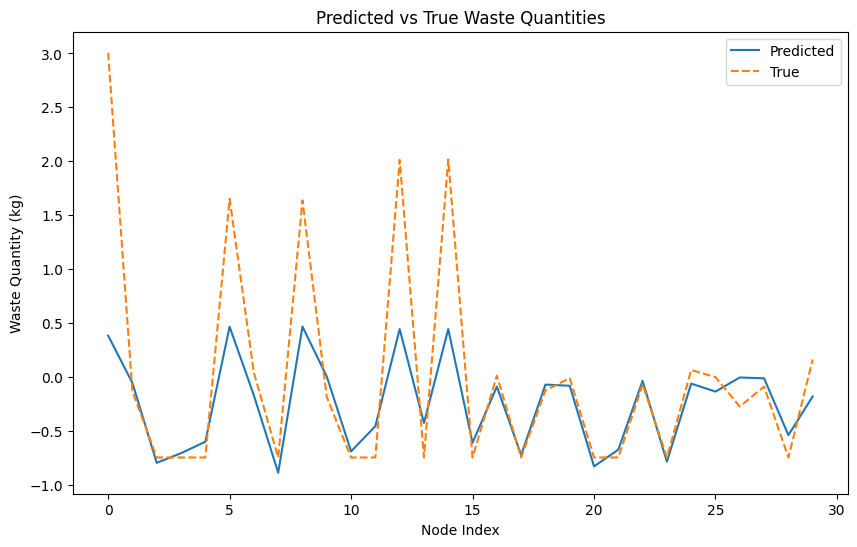

GCN+LSTM

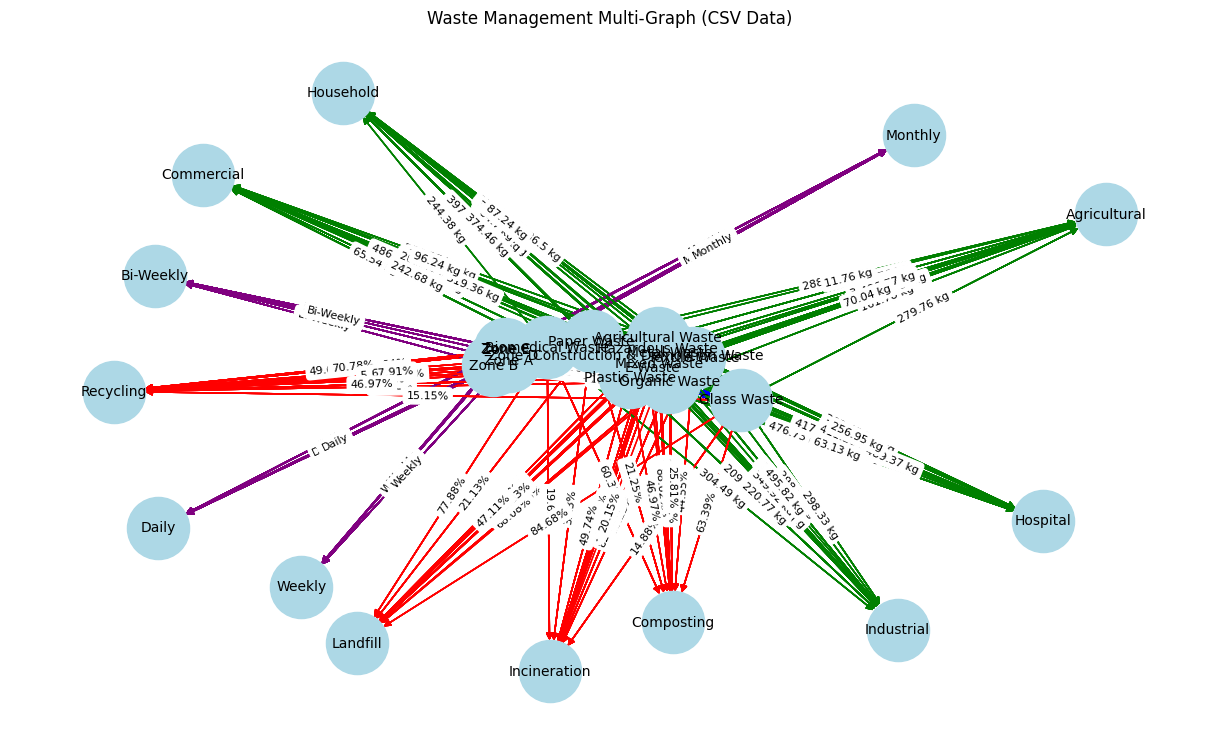

In [73]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load CSV file
file_path = "waste_classification_data.csv"  # Update with the actual path
df = pd.read_csv(file_path)

# Create MultiDiGraph
G = nx.MultiDiGraph()

# Add Nodes & Edges
for _, row in df.iterrows():
    area = row["Area Name"]
    waste = row["Waste Type"]
    qty = row["Waste Quantity (kg)"]
    source = row["Source"]
    recyclability = row["Recyclability Score (%)"]
    disposal = row["Disposal Method"]
    frequency = row["Collection Frequency"]

    # Add edges with labels
    G.add_edge(area, waste, weight=qty, label=f"{qty} kg")  # Waste Flow
    G.add_edge(waste, disposal, weight=recyclability, label=f"{recyclability}%")  # Disposal Efficiency
    G.add_edge(waste, source, weight=qty, label=f"{qty} kg")  # Source Contribution
    G.add_edge(area, frequency, weight=qty, label=frequency)  # Collection Frequency

# Define Edge Colors
color_map = {
    "Waste Flow": "blue",
    "Disposal Efficiency": "red",
    "Source Contribution": "green",
    "Collection Frequency": "purple"
}

edge_labels = {}
edge_colors = []

for u, v, data in G.edges(data=True):
    if v in df["Waste Type"].values:
        edge_type = "Waste Flow"
    elif v in df["Disposal Method"].values:
        edge_type = "Disposal Efficiency"
    elif v in df["Source"].values:
        edge_type = "Source Contribution"
    else:
        edge_type = "Collection Frequency"
    
    edge_labels[(u, v)] = data["label"]
    edge_colors.append(color_map[edge_type])

# Draw Graph
plt.figure(figsize=(12, 7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, edge_color=edge_colors, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Waste Management Multi-Graph (CSV Data)")
plt.show()


In [74]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data
import numpy as np

# Load CSV file
file_path = "waste_classification_data.csv"  # Update with the actual path
df = pd.read_csv(file_path)

# Create a MultiDiGraph
G = nx.MultiDiGraph()

# Add Nodes and Edges (as before)
for _, row in df.iterrows():
    area = row["Area Name"]
    waste = row["Waste Type"]
    qty = row["Waste Quantity (kg)"]
    source = row["Source"]
    recyclability = row["Recyclability Score (%)"]
    disposal = row["Disposal Method"]
    frequency = row["Collection Frequency"]

    G.add_edge(area, waste, weight=qty, label=f"{qty} kg")  # Waste Flow
    G.add_edge(waste, disposal, weight=recyclability, label=f"{recyclability}%")  # Disposal Efficiency
    G.add_edge(waste, source, weight=qty, label=f"{qty} kg")  # Source Contribution
    G.add_edge(area, frequency, weight=qty, label=frequency)  # Collection Frequency

# Create a mapping from node labels to integer indices
node_list = list(G.nodes())
node_to_idx = {node: idx for idx, node in enumerate(node_list)}

# Convert the graph into edge_index format for PyTorch Geometric
edges = list(G.edges())
edge_index = torch.tensor([[node_to_idx[u], node_to_idx[v]] for u, v in edges], dtype=torch.long).t().contiguous()

# Convert edge attributes (weights) to tensor
edge_attr = torch.tensor([G[u][v][0]['weight'] for u, v in edges], dtype=torch.float)

# Initialize waste_history for all zones
waste_history = {zone: [] for zone in node_list}

# Collect the last 7 days of waste data for each zone
for _, row in df.iterrows():
    area = row["Area Name"]
    qty = row["Waste Quantity (kg)"]
    
    if len(waste_history[area]) < 7:
        waste_history[area].append(qty)
    else:
        waste_history[area] = waste_history[area][1:] + [qty]

# Ensure all zones have data (fill with 0 if not enough data)
for zone in node_list:
    if len(waste_history[zone]) < 7:
        waste_history[zone] = [0] * (7 - len(waste_history[zone])) + waste_history[zone]

# Convert to DataFrame for node features
waste_df = pd.DataFrame.from_dict(waste_history, orient='index')
waste_df = waste_df.fillna(0)

# Convert the waste history DataFrame to a tensor
node_features = torch.tensor(waste_df.values, dtype=torch.float)

# Ensure that node_features matches the number of nodes
assert node_features.size(0) == len(node_list), f"Expected {len(node_list)} nodes, but got {node_features.size(0)}"

# Prepare the PyTorch Geometric data object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

# Check the data object
print(data)


Data(x=[30, 7], edge_index=[2, 2000], edge_attr=[2000])


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils import scatter
from torch.utils.data import DataLoader, TensorDataset

# ✅ Sample Data
num_nodes = 10  # Adjust based on your dataset
num_features = 5
num_edges = 15  # Adjust for more connections
num_timesteps = 7  # Number of time steps for LSTM

# Random feature matrix (10 nodes, 5 features each)
x = torch.rand(num_nodes, num_features)

# Random edge index (2, num_edges) ensuring it's within valid node range
edge_index = torch.randint(0, num_nodes, (2, num_edges))

# ✅ Debug: Check edge_index validity
print("Number of nodes:", x.shape[0])
print("Max node index in edge_index:", edge_index.max().item())

# Ensure edge_index does not contain out-of-bounds indices
if edge_index.max().item() >= x.shape[0]:
    valid_mask = edge_index < x.shape[0]
    edge_index = edge_index[:, valid_mask.all(dim=0)]
    print("Filtered Edge Index:", edge_index)

# Labels (random values for regression)
y = torch.rand(num_nodes, 1)

# Create a dataset and dataloader
dataset = TensorDataset(x, y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(dataset, batch_size=4, shuffle=False)

# ✅ Define GCN-LSTM Model
class GCN_LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, lstm_hidden_dim):
        super(GCN_LSTM, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, lstm_hidden_dim, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = torch.relu(x)
        x = self.gcn2(x, edge_index)
        x = torch.relu(x)
        
        # LSTM requires (batch, seq_len, features), so reshape
        x = x.unsqueeze(1)  # Add sequence dimension (1 time step)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take last time step
        
        return self.fc(lstm_out)

# ✅ Initialize Model
input_dim = num_features
hidden_dim = 16
output_dim = 1
lstm_hidden_dim = 8

model = GCN_LSTM(input_dim, hidden_dim, output_dim, lstm_hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ✅ Training Function
def train_model(model, train_loader, test_loader, edge_index, num_epochs=50):
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x, edge_index)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_loss = 0
            for batch_x, batch_y in test_loader:
                outputs = model(batch_x, edge_index[:4])
                test_loss += criterion(outputs, batch_y).item()
            test_loss /= len(test_loader)

        # Save best model
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model.state_dict(), "best_model.pth")

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Test Loss: {test_loss:.4f}")

# ✅ Train Model
train_model(model, train_loader, test_loader, edge_index[:4])

# ✅ Evaluate Model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    sample_x = torch.rand(num_nodes, num_features)
    predictions = model(sample_x, edge_index)
    print("Predictions:", predictions)


Number of nodes: 10
Max node index in edge_index: 9


RuntimeError: index 8 is out of bounds for dimension 0 with size 4

In [85]:
print(f"x shape: {x.shape}")  # Should match the number of nodes
print(f"edge_index max: {edge_index.max()}")  # Should be < x.shape[0]
print(f"num_nodes: {x.shape[0]}")


x shape: torch.Size([10, 5])
edge_index max: 9
num_nodes: 10


In [86]:
print(f"edge_index shape: {edge_index.shape}")
print(f"edge_index: {edge_index}")


edge_index shape: torch.Size([2, 15])
edge_index: tensor([[8, 0, 3, 3, 7, 3, 1, 6, 9, 1, 3, 2, 9, 1, 6],
        [8, 6, 7, 2, 8, 2, 2, 4, 0, 4, 0, 0, 2, 1, 7]])


In [87]:
print(f"edge_index max: {edge_index.max()}")
print(f"edge_index min: {edge_index.min()}")


edge_index max: 9
edge_index min: 0


In [88]:
print(x)


tensor([[0.6958, 0.5169, 0.0638, 0.4260, 0.7966],
        [0.6561, 0.2562, 0.8297, 0.8731, 0.0525],
        [0.9325, 0.6520, 0.5682, 0.3011, 0.6964],
        [0.2832, 0.3003, 0.1775, 0.5737, 0.8586],
        [0.8005, 0.9683, 0.2716, 0.3267, 0.6664],
        [0.1447, 0.8651, 0.4115, 0.0874, 0.7297],
        [0.6265, 0.6637, 0.5068, 0.1333, 0.0663],
        [0.2860, 0.4033, 0.0601, 0.2291, 0.5515],
        [0.5122, 0.1794, 0.9133, 0.3078, 0.0163],
        [0.3364, 0.3537, 0.8570, 0.1395, 0.2531]])
